In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# matplotlib.pyplot 한글 깨짐 방지
import platform
from matplotlib import font_manager, rc

if platform.system() == "Darwin":
    print("Hangul Setting OK for Mac")
    rc("font", family = "Arial Unicode MS")
elif platform.system() == "Windows":
    print("This py not setting for Window sry")
else:
    print("We don't know System")

Hangul Setting OK for Mac


In [3]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16541 entries, 0 to 16540
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      16541 non-null  object
 1   문장      16541 non-null  object
 2   유형      16541 non-null  object
 3   극성      16541 non-null  object
 4   시제      16541 non-null  object
 5   확실성     16541 non-null  object
 6   label   16541 non-null  object
dtypes: object(7)
memory usage: 904.7+ KB


In [74]:
train['극성'].value_counts()

긍정    15793
부정      565
미정      183
Name: 극성, dtype: int64

In [4]:
import re

def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 한글 추출 규칙: 띄어 쓰기(1 개)를 포함한 한글
    result = hangul.sub('', text)  # 위에 설정한 "hangul"규칙을 "text"에 적용(.sub)시킴
    return result

In [5]:
from konlpy.tag import Okt
from collections import Counter

# 형태소 추출
okt = Okt()  # 명사 형태소 추출 함수
nouns = okt.nouns(apply_regular_expression(train['문장'][0]))
nouns

['포인트', '금리', '인상', '년', '이후', '년', '처음']

In [41]:
# 불용어 사전 불러오기
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()

def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', str(text))
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]  # 한글자 키워드 제거 
    nouns = [x for x in nouns if x not in stopwords]  # 불용어 제거
    return nouns

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(train['문장'].tolist())
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis=0)

In [43]:
# 단어 빈도수 DataFrame
word_df = pd.DataFrame({
    'word' : word_list,
    'count' : count_list
})

# 빈도수 많은 순으로 정렬
word_df.sort_values('count', ascending=False, inplace=True)

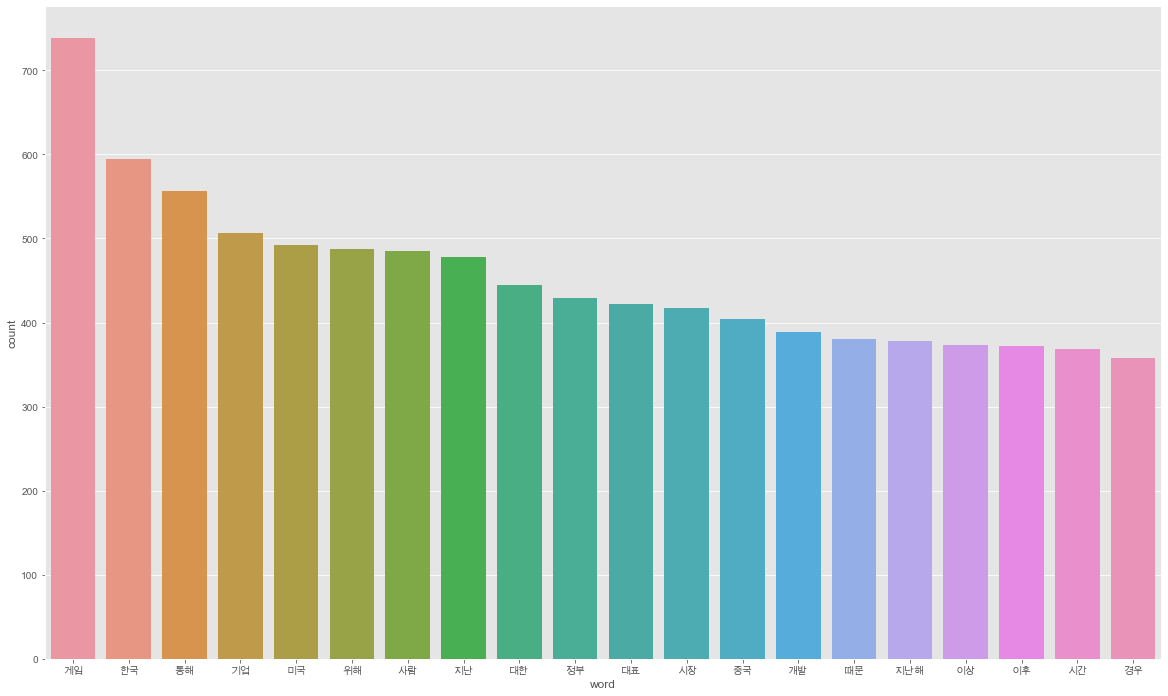

In [44]:
# 빈도수가 많은 20개 단어 시각화

plt.style.use('ggplot')
plt.figure(figsize=(20,12))
sns.barplot(data = word_df[:20], x='word', y='count')
plt.show()


In [45]:
corpus = "".join(train['문장'].tolist())
nouns = okt.nouns(apply_regular_expression(corpus))
counts = Counter(text_cleaning(nouns))

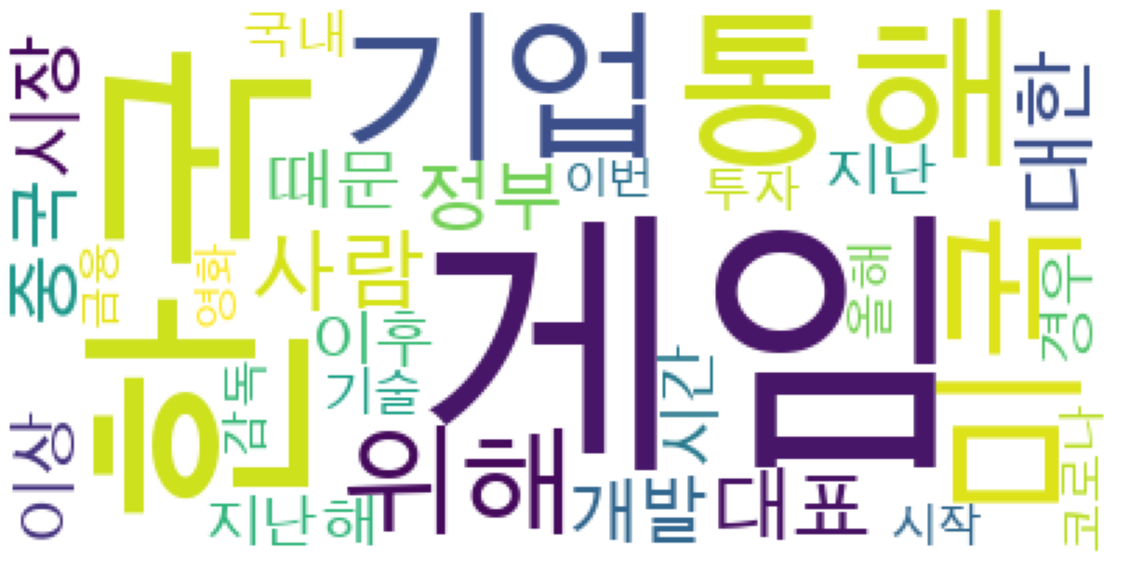

In [46]:
# 워드 클라우딩 사용자 함수
from wordcloud import WordCloud

font_path = '/System/Library/Fonts/Supplemental/Arial Unicode.ttf'
    
def wordCloudingMulti(words):
    
    plt.figure(figsize=(20,12))
    wc = WordCloud(font_path= font_path ,background_color="white", max_font_size=100)
    cloud = wc.generate_from_frequencies(dict(words))
    
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()


wordCloudingMulti(counts.most_common(30))

### 극성 구분
 - 방법1. 긍정, 부정, 미정의 단어 사전을 각각 만들고 중복되는 단어를 제거한다.

In [47]:
train['극성'].unique()

array(['긍정', '부정', '미정'], dtype=object)

In [48]:
pos_df = train[train['극성'] == '긍정']
nega_df = train[train['극성'] == '부정']
neu_df = train[train['극성'] == '미정']

pol_list = [pos_df, nega_df, neu_df]

In [49]:
len(pos_df), len(nega_df), len(neu_df)

(15793, 565, 183)

In [50]:
# 극성 별 단어 빈도수 만들기

for pol_df in pol_list:
    corpus = "".join(pol_df['문장'].tolist())
    nouns = okt.nouns(apply_regular_expression(corpus))
    if pol_df.iloc[0]['극성'] == '긍정':
        pos_dict = Counter(text_cleaning(nouns))
    elif pol_df.iloc[0]['극성'] == '부정':
        nega_dict = Counter(text_cleaning(nouns))
    else:
        neu_dict =  Counter(text_cleaning(nouns))

In [51]:
len(pos_dict), len(nega_dict), len(neu_dict)

(19534, 2498, 1127)

In [52]:
# 구분된 사전에서 다른 사전과 겹치는 단어는 제거

pop_list = []
for key in pos_dict.keys():
    isPop = False
    if nega_dict[key] != 0 :
        isPop = True
        nega_dict.pop(key)
    
    if neu_dict[key] != 0:
        isPop = True
        neu_dict.pop(key)

    if isPop:
        pop_list.append(key)

for p in pop_list:
    pos_dict.pop(p)

pop_list.clear()

for key in nega_dict.keys():
    if neu_dict[key] != 0:
        neu_dict.pop(key)
        pop_list.append(key)

for p in pop_list:
    nega_dict.pop(p)
    

In [53]:
len(pos_dict), len(nega_dict), len(neu_dict)

(16708, 211, 70)

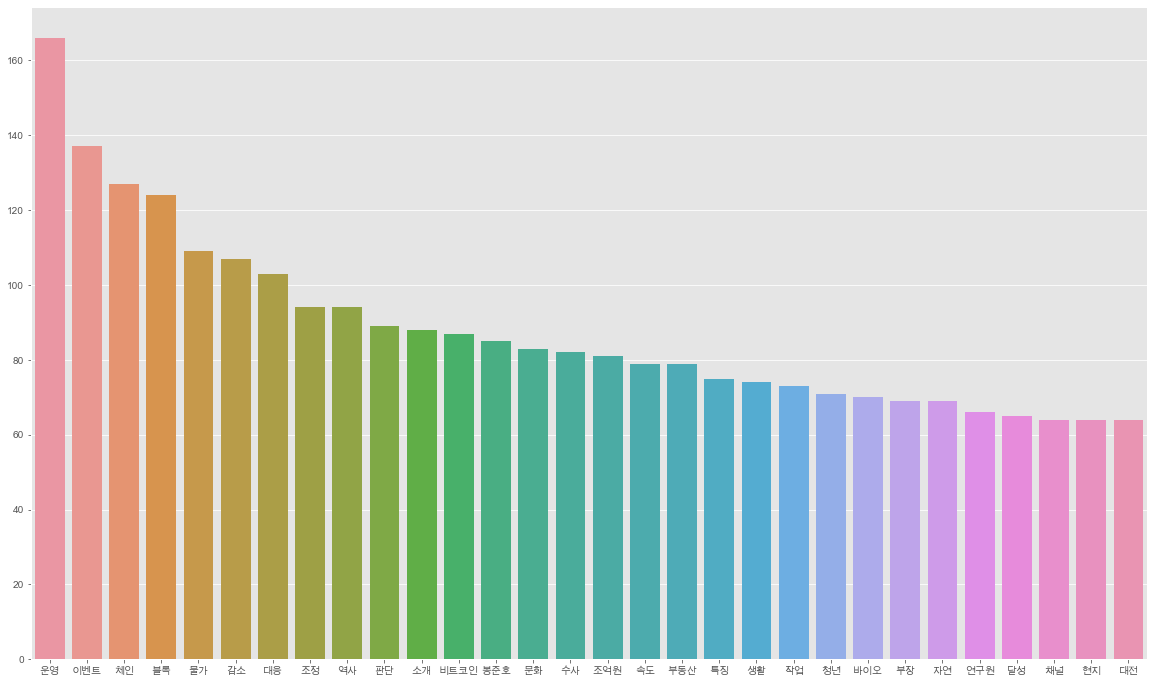

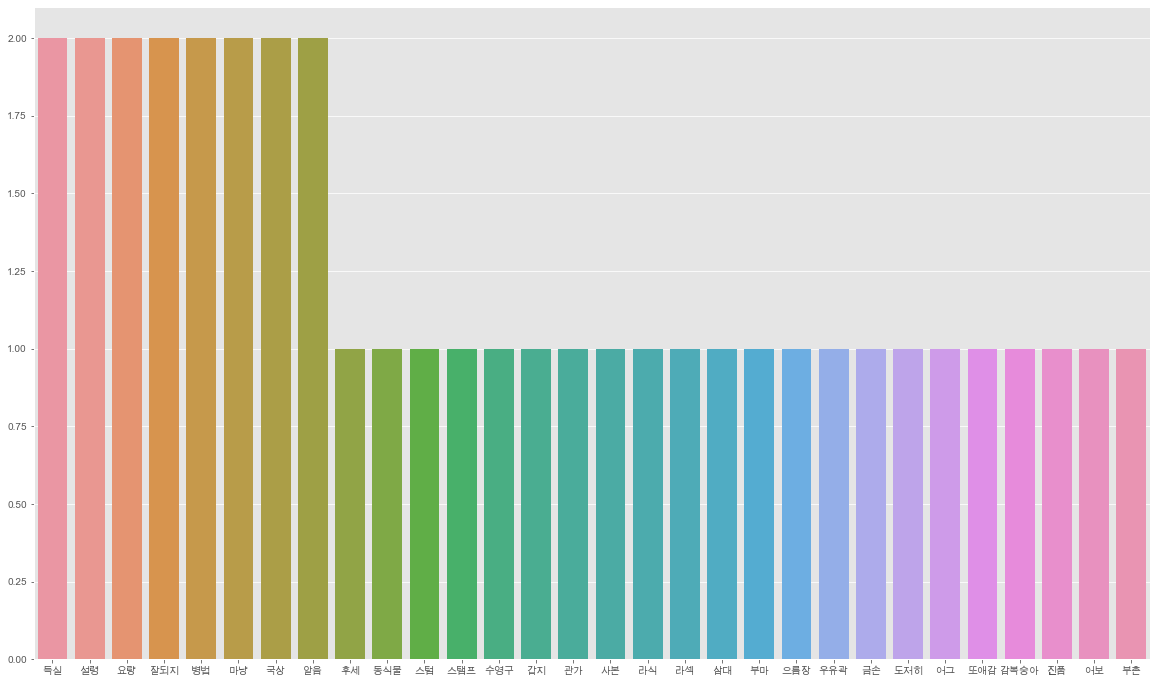

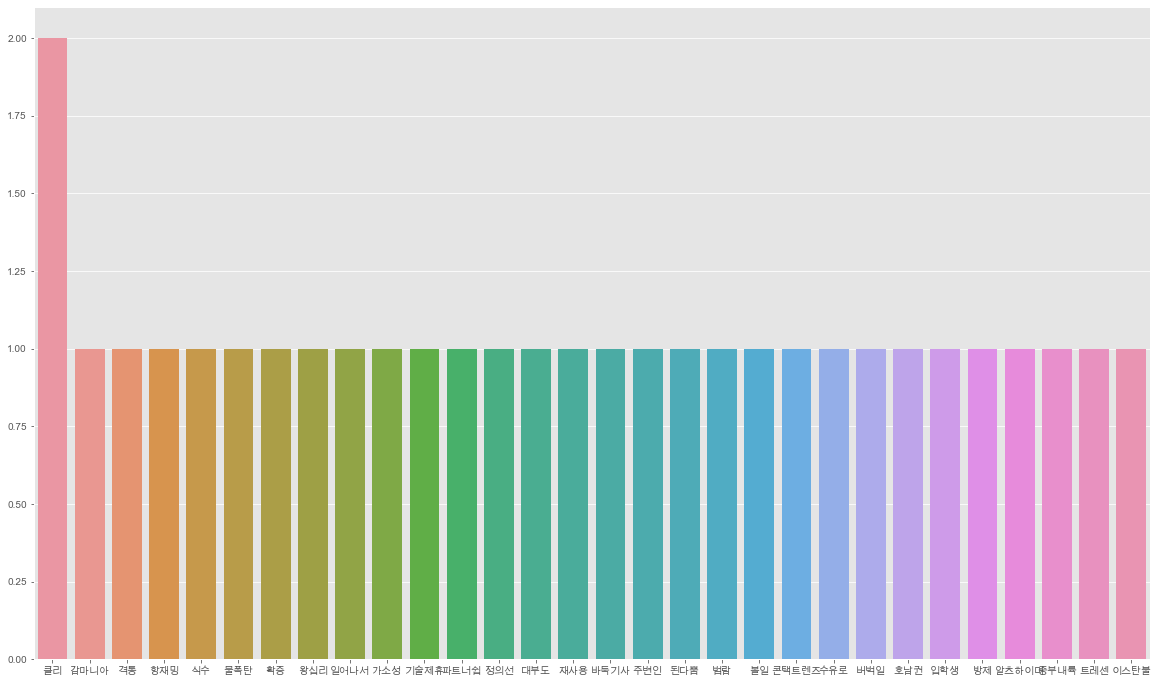

In [54]:
pol_dicts = [pos_dict, nega_dict, neu_dict]

for pol_dict in pol_dicts:
    plt.figure(figsize=(20,12))

    most_30 = pol_dict.most_common(30)

    sns.barplot(x=[x[0] for x in most_30], y= [y[1] for y in most_30])

    plt.show()

중복 단어를 제거했더니 긍정 분류의 경우 단어 빈도수가 그래도 높은 단어들이 많았지만 부정과 중립의 경우 그렇지 못했다. 중복된 단어를 양쪽에서 제거하는게 아니라 빈도수가 높은쪽만 남기는 방법으로 다시 확인해보기로 함.

In [55]:
for pol_df in pol_list:
    corpus = "".join(pol_df['문장'].tolist())
    nouns = okt.nouns(apply_regular_expression(corpus))
    if pol_df.iloc[0]['극성'] == '긍정':
        pos_dict = Counter(text_cleaning(nouns))
    elif pol_df.iloc[0]['극성'] == '부정':
        nega_dict = Counter(text_cleaning(nouns))
    else:
        neu_dict =  Counter(text_cleaning(nouns))

In [56]:
len(pos_dict), len(nega_dict), len(neu_dict)

(19534, 2498, 1127)

In [57]:
# 구분된 사전에서 다른 사전과 겹치는 단어는 제거

pop_list = []
for key, value in pos_dict.items():
    isPop = False
    if nega_dict[key] != 0 :
        if value < nega_dict[key]:
            isPop = True
        else:
            nega_dict.pop(key)
    
    if neu_dict[key] != 0:
        if value < neu_dict[key]:
            isPop = True
        else:
            neu_dict.pop(key)

    if isPop:
        pop_list.append(key)

for p in pop_list:
    pos_dict.pop(p)

pop_list.clear()

for key, value in nega_dict.items():
    if neu_dict[key] != 0:
        if value < neu_dict[key]:
            neu_dict.pop(key)
        else:
            pop_list.append(key)

for p in pop_list:
    nega_dict.pop(p)
    

In [58]:
len(pos_dict), len(nega_dict), len(neu_dict)

(19514, 223, 79)

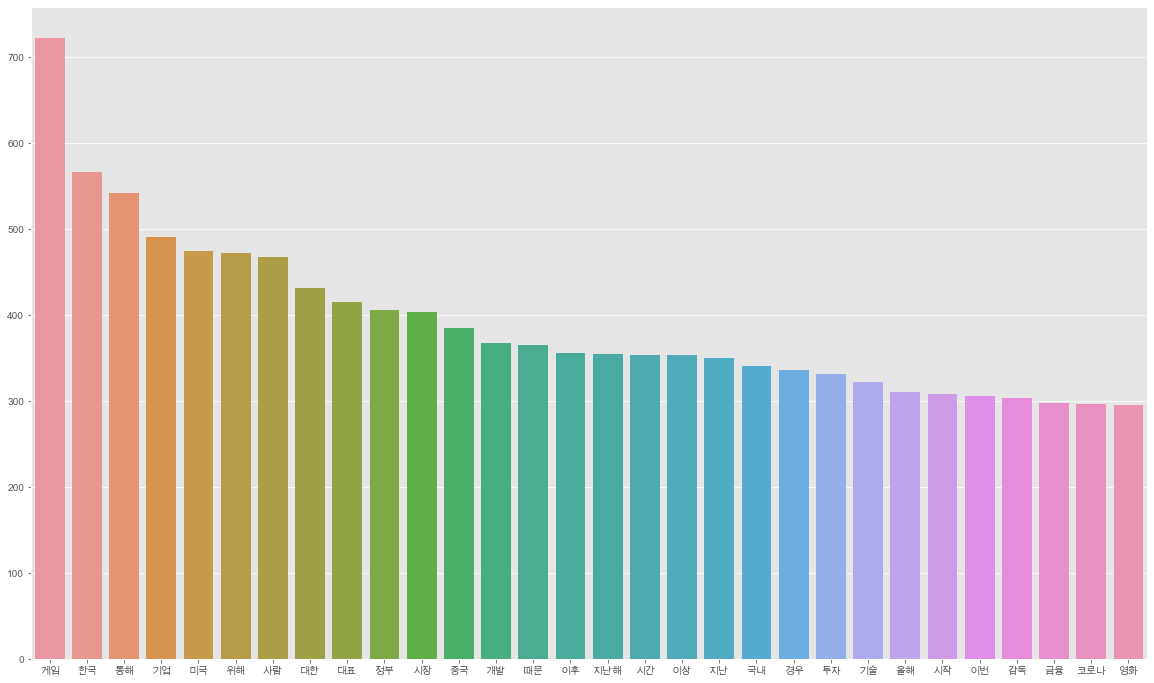

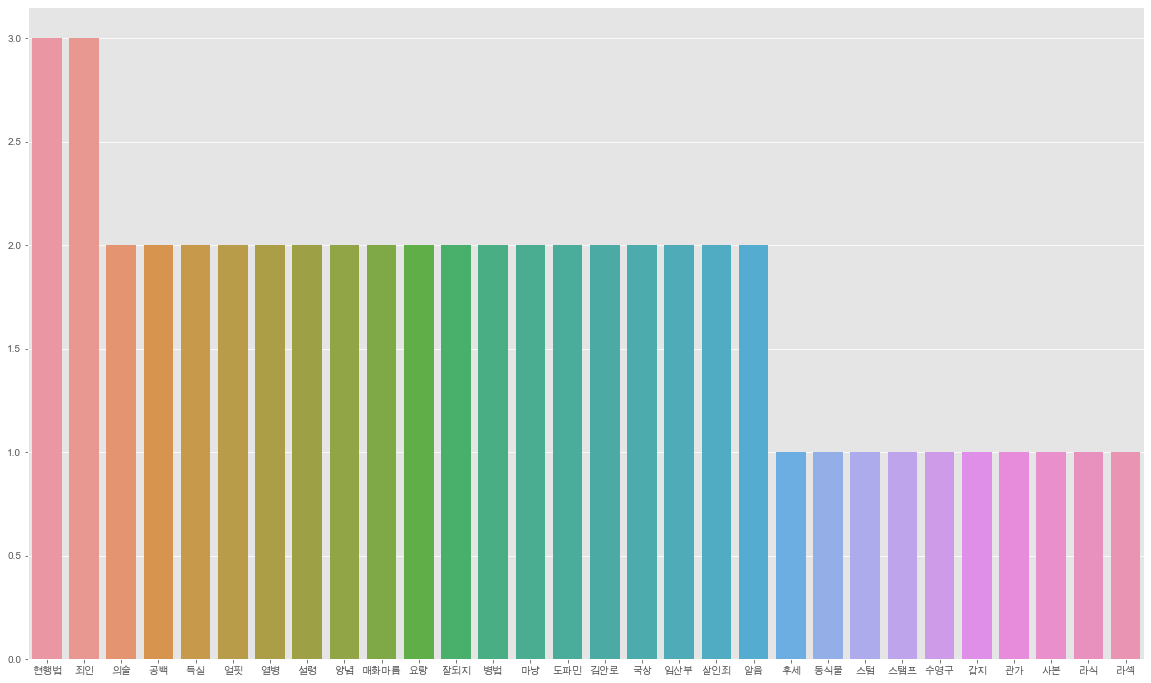

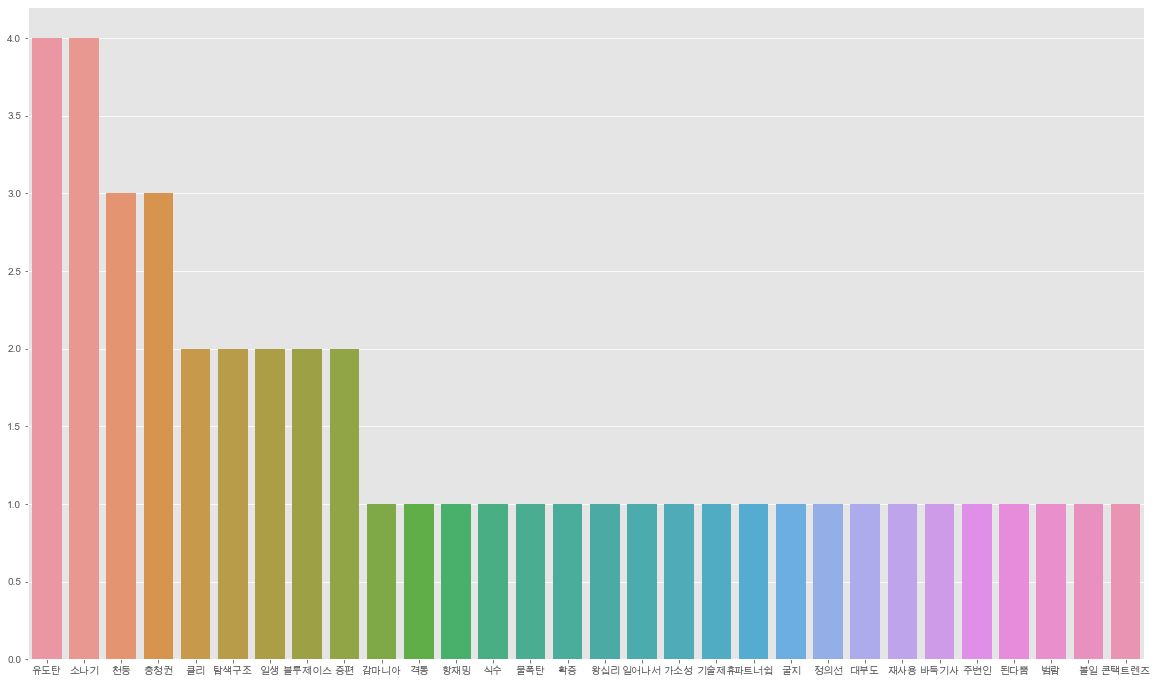

In [59]:
pol_dicts = [pos_dict, nega_dict, neu_dict]

for pol_dict in pol_dicts:
    plt.figure(figsize=(20,12))

    most_30 = pol_dict.most_common(30)

    sns.barplot(x=[x[0] for x in most_30], y= [y[1] for y in most_30])

    plt.show()

여전히 각 사전의 빈도수에는 큰 차이가 있었음. 이는 긍정으로 분류된 문장들이 수가 워낙 많아서 발생한 것으로 보여 해당 전처리 방법은 사용하기 어려움.

### 다른 분류 방법
- 방법 2
    1) 긍정, 부정, 미정의 사전으로 분리 후 테스트 데이터의 문장의 형태소에서 각 라벨에 속하는 횟수를 확인하여 분류 성능을 확인한다.
    2) 각 분류된 극성마다 단어 사전의 중요도(tfidf)를 적용하여 예측한다.
    

#### 횟수를 통한 분류

In [60]:
# 극성의 3가지 특성(긍정, 부정, 미정) 3가지 분류의 사전으로 분류
for pol_df in pol_list:
    corpus = "".join(pol_df['문장'].tolist())
    nouns = okt.nouns(apply_regular_expression(corpus))
    if pol_df.iloc[0]['극성'] == '긍정':
        pos_dict = Counter(text_cleaning(nouns))
    elif pol_df.iloc[0]['극성'] == '부정':
        nega_dict = Counter(text_cleaning(nouns))
    else:
        neu_dict =  Counter(text_cleaning(nouns))

In [61]:
# 타겟 문장에 긍정, 부정, 미정 단어 카운트(중복O)
def getCnt(df):
    pos_cnt = []
    nega_cnt = []
    neu_cnt = []
    for idx, row in df.iterrows():
        corpus = "".join(row['문장'])
        nouns = text_cleaning(okt.nouns(apply_regular_expression(corpus)))

        cnt1 = 0
        cnt2 = 0
        cnt3 = 0
        
        for word in nouns:
            if word in pos_dict:
                cnt1+=1
            if word in nega_dict:
                cnt2+=1
            if word in neu_dict:
                cnt3+=1

        pos_cnt.append(cnt1), nega_cnt.append(cnt2), neu_cnt.append(cnt3)

    cnt_df = pd.DataFrame({
        'pos' : pos_cnt,
        'nega' : nega_cnt,
        'neu' : neu_cnt
    })

    return cnt_df

train_cnt = getCnt(train)

#### 사전별 단어 중요도 정리

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

pos_corpus = "".join(pos_df['문장'].tolist())
nega_corpus = "".join(nega_df['문장'].tolist())
neu_corpus = "".join(neu_df['문장'].tolist())

pos_nouns = okt.nouns(apply_regular_expression(pos_corpus))
nega_nouns = okt.nouns(apply_regular_expression(nega_corpus))
neu_nouns = okt.nouns(apply_regular_expression(neu_corpus))


pos_strings = " ".join(text_cleaning(pos_nouns))
nega_strings = " ".join(text_cleaning(nega_nouns))
neu_strings = " ".join(text_cleaning(neu_nouns))


tfdif = TfidfVectorizer()
pos_tfidf = tfdif.fit_transform([pos_strings])
pos_voca = tfdif.vocabulary_
nega_tfidf = tfdif.fit_transform([nega_strings])
nega_voca = tfdif.vocabulary_
neu_tfidf = tfdif.fit_transform([neu_strings])
neu_voca = tfdif.vocabulary_


pos_prob = {x : y for x, y in zip(pos_tfidf.indices, pos_tfidf.data)}
nega_prob = {x : y for x, y in zip(nega_tfidf.indices, nega_tfidf.data)}
neu_prob = {x : y for x, y in zip(neu_tfidf.indices, neu_tfidf.data)}


#### 모델 예측
- 통계적 분류(횟수)

In [63]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score, f1_score

from sklearn.preprocessing import LabelEncoder

e = LabelEncoder()
e.fit(train['극성'])

X = train_cnt
y = e.transform(train['극성'])
# y = train['극성'] # 딥러닝이 아니라 정수형태로 넘겨주지 않아도 분류 자체는 가능

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size=0.2)

tree = DecisionTreeClassifier()
rf = RandomForestClassifier()

tree.fit(X_train, y_train)
rf.fit(X_train, y_train)

pred_tree = tree.predict(X_test)
pred_rf = rf.predict(X_test)

print('Decision accuracy_score : ', accuracy_score(y_test, pred_tree))
print('Decision f1_score : ', f1_score(y_test, pred_tree, average='weighted'))

print('RandomForest accuracy_score : ', accuracy_score(y_test, pred_rf))
print('RandomForest f1_score : ', f1_score(y_test, pred_rf, average='weighted'))



Decision accuracy_score :  0.9749168933212451
Decision f1_score :  0.972835152494786
RandomForest accuracy_score :  0.9740102750075551
RandomForest f1_score :  0.9716662900947158


In [64]:
# 검증 데이터 중 예측 실패한 데이터 - tree
false_tree = []
for idx, (true, pred) in enumerate(zip(y_test, pred_tree)):
    if true != pred:
        false_tree.append(X_test.iloc[[idx]].index[0])

train.iloc[false_tree]

,ID,문장,유형,극성,시제,확실성,label
436,TRAIN_00436,최대 8인의 전투부대를 구성해 지옥성물함 공격대 우두머리에 도전할 수 있으며 150...,추론형,미정,미래,불확실,추론형-미정-미래-불확실
2872,TRAIN_02872,만약 투자자들 주장이 사실로 입증되면 판매사들도 법적 책임을 면하기 어려울 것으로 ...,추론형,긍정,미래,확실,추론형-긍정-미래-확실
2733,TRAIN_02733,"숙박 O2O(Online to Offline, 온라인 기반 오프라인) 플랫폼 업계 ...",예측형,미정,미래,불확실,예측형-미정-미래-불확실
2511,TRAIN_02511,아! 어찌 부인의 필치라고 소홀히 다뤄져서야 되겠는가.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
2566,TRAIN_02566,과거 우리 선배들의 성공방식은 더 이상 통용되기 어렵게 됐다.,추론형,부정,과거,확실,추론형-부정-과거-확실
...,...,...,...,...,...,...,...
14745,TRAIN_14745,사정이 이렇다 보니 최근 10년간 퇴직연금 수익률이 연 3%를 넘어선 적이 거의 없...,대화형,부정,과거,확실,대화형-부정-과거-확실
2632,TRAIN_02632,정부가 항공우주 산업 육성에 적극적인 태도를 보이는 것도 관련 핵심 기술을 보유한 ...,사실형,긍정,현재,확실,사실형-긍정-현재-확실
7445,TRAIN_07445,뉴턴의 사례가 극명하게 말해주듯 우리는 거품 속에서 거품을 볼 수 없다.,사실형,부정,현재,확실,사실형-부정-현재-확실
1575,TRAIN_01575,과거 ＇교육＇은 모든 국민이 오를 수 있는 사다리였다.,사실형,긍정,과거,확실,사실형-긍정-과거-확실


In [65]:
train.iloc[false_tree]['극성'].value_counts()

부정    50
긍정    20
미정    13
Name: 극성, dtype: int64

In [66]:
# 검증 데이터 중 예측 실패한 데이터 - RDF
false_rf = []
for idx, (true, pred) in enumerate(zip(y_test, pred_rf)):
    if true != pred:
        false_rf.append(X_test.iloc[[idx]].index[0])

train.iloc[false_rf]

,ID,문장,유형,극성,시제,확실성,label
436,TRAIN_00436,최대 8인의 전투부대를 구성해 지옥성물함 공격대 우두머리에 도전할 수 있으며 150...,추론형,미정,미래,불확실,추론형-미정-미래-불확실
2872,TRAIN_02872,만약 투자자들 주장이 사실로 입증되면 판매사들도 법적 책임을 면하기 어려울 것으로 ...,추론형,긍정,미래,확실,추론형-긍정-미래-확실
2733,TRAIN_02733,"숙박 O2O(Online to Offline, 온라인 기반 오프라인) 플랫폼 업계 ...",예측형,미정,미래,불확실,예측형-미정-미래-불확실
2511,TRAIN_02511,아! 어찌 부인의 필치라고 소홀히 다뤄져서야 되겠는가.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
2566,TRAIN_02566,과거 우리 선배들의 성공방식은 더 이상 통용되기 어렵게 됐다.,추론형,부정,과거,확실,추론형-부정-과거-확실
...,...,...,...,...,...,...,...
7445,TRAIN_07445,뉴턴의 사례가 극명하게 말해주듯 우리는 거품 속에서 거품을 볼 수 없다.,사실형,부정,현재,확실,사실형-부정-현재-확실
1575,TRAIN_01575,과거 ＇교육＇은 모든 국민이 오를 수 있는 사다리였다.,사실형,긍정,과거,확실,사실형-긍정-과거-확실
12881,TRAIN_12881,특히 항암치료 중 면역력을 높여 암세포가 사멸하도록 돕는 한의학 면역치료를 병행하면...,사실형,긍정,현재,확실,사실형-긍정-현재-확실
2554,TRAIN_02554,"연일 들려오는 민간항공시장 상황은 운항 중단에 따른 여파가 폭풍 전야로, 민간항공사...",사실형,부정,현재,확실,사실형-부정-현재-확실


In [67]:
train.iloc[false_rf]['극성'].value_counts()

부정    52
긍정    20
미정    14
Name: 극성, dtype: int64

In [68]:
false_cross = [x for x in false_tree if x in false_rf]

train.iloc[false_cross]

,ID,문장,유형,극성,시제,확실성,label
436,TRAIN_00436,최대 8인의 전투부대를 구성해 지옥성물함 공격대 우두머리에 도전할 수 있으며 150...,추론형,미정,미래,불확실,추론형-미정-미래-불확실
2872,TRAIN_02872,만약 투자자들 주장이 사실로 입증되면 판매사들도 법적 책임을 면하기 어려울 것으로 ...,추론형,긍정,미래,확실,추론형-긍정-미래-확실
2733,TRAIN_02733,"숙박 O2O(Online to Offline, 온라인 기반 오프라인) 플랫폼 업계 ...",예측형,미정,미래,불확실,예측형-미정-미래-불확실
2511,TRAIN_02511,아! 어찌 부인의 필치라고 소홀히 다뤄져서야 되겠는가.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
2566,TRAIN_02566,과거 우리 선배들의 성공방식은 더 이상 통용되기 어렵게 됐다.,추론형,부정,과거,확실,추론형-부정-과거-확실
...,...,...,...,...,...,...,...
14745,TRAIN_14745,사정이 이렇다 보니 최근 10년간 퇴직연금 수익률이 연 3%를 넘어선 적이 거의 없...,대화형,부정,과거,확실,대화형-부정-과거-확실
2632,TRAIN_02632,정부가 항공우주 산업 육성에 적극적인 태도를 보이는 것도 관련 핵심 기술을 보유한 ...,사실형,긍정,현재,확실,사실형-긍정-현재-확실
7445,TRAIN_07445,뉴턴의 사례가 극명하게 말해주듯 우리는 거품 속에서 거품을 볼 수 없다.,사실형,부정,현재,확실,사실형-부정-현재-확실
1575,TRAIN_01575,과거 ＇교육＇은 모든 국민이 오를 수 있는 사다리였다.,사실형,긍정,과거,확실,사실형-긍정-과거-확실


In [69]:
train_cnt.iloc[false_cross]

,pos,nega,neu
436,17,6,17
2872,8,8,2
2733,16,11,16
2511,2,2,1
2566,6,6,2
...,...,...,...
14745,6,6,2
2632,13,8,12
7445,5,5,4
1575,5,5,2


#### 모델 평가
해당 전처리와 분류 방법에 정확도는 높게 나왔지만 좋은 모델이라 하기는 어렵다. 그 이유는 아래와 같다.
- 단어 등장 횟수에 따른 분리로 학습할 데이터의 수가 부족하거나 새로운 단어들로만 구성된 문장이 등장한다면 정확한 예측을 할 수 없음.  
- 같은 문장의 경우 긍정적인 단어의 빈도수가 높아 긍정으로 오분류 가능성이 있다. 즉, 문장의 문맥 파악이 어려워 정확한 분류가 어렵다는 것이다.
    - 예시 문장) '정부가 신혼부부들을 위한 새로운 정책을 다수 발표하여 긍정적인 반응을 기대하고 있지만 신혼부부들에게 좋은 반응을 얻기 어려울 것으로 보인다.'
- 현재 사용한 훈련, 테스트 데이터는 맞춤법, 띄어쓰기 등 깔끔하게 정재된 데이터이기 때문에 높은 정확성이 나왔지만 인터넷에 있는 정재되지 않은 문장에 대한 예측이라면 예측하기 어려움.

In [70]:
# '정부가 신혼부부들을 위한 새로운 정책을 다수 발표하여 긍정적인 반응을 기대하고 있지만 신혼부부들에게 좋은 반응을 얻기 어려울 것으로 보인다.' 테스트
temp = pd.DataFrame({
    '문장' : ['정부가 신혼부부들을 위한 새로운 정책을 다수 발표하여 긍정적인 반응을 기대하고 있지만 신혼부부들에게 좋은 반응을 얻기 어려울 것으로 보인다.']
})

temp = getCnt(temp)
tree.predict(temp)[0], rf.predict(temp)[0] # 0 긍정, 1 부정, 2 미정

(0, 0)

- 중요도 분류

In [71]:
def getPorb(df, pos_prob, nega_prob, neu_prob):
    pp = []
    np = []
    neup = []
    for idx, row in df.iterrows():
        corpus = "".join(row['문장'])
        nouns = text_cleaning(okt.nouns(apply_regular_expression(corpus)))

        pp_sum = 0
        np_sum = 0
        neup_sum = 0

        try:
            for word in nouns:
                if word in pos_dict:
                    pp_sum += pos_prob[pos_voca[word]]
                if word in nega_dict:
                    np_sum += nega_prob[nega_voca[word]]
                if word in neu_dict:
                    neup_sum += neu_prob[neu_voca[word]]
        except:
            print("None Train Data : {}" .format(word))
        pp.append(pp_sum), np.append(np_sum), neup.append(neup_sum)

    cnt_df = pd.DataFrame({
        'pos' : pp,
        'nega' : np,
        'neu' : neup
    })

    return cnt_df

train_prob = getPorb(train, pos_prob, nega_prob, neu_prob)

In [72]:
train_prob['True Data'] = train['극성']


In [73]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

tree = DecisionTreeClassifier()
rdf = RandomForestClassifier()
logistic = LogisticRegression()

X = train_prob.drop('True Data', axis =1 )
y = e.transform(train['극성'])

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=13)

tree.fit(X_train, y_train)
rdf.fit(X_train, y_train)
logistic.fit(X_train, y_train)

pred_tree = tree.predict(X_test)
pred_rdf = rdf.predict(X_test)
pred_logistic = logistic.predict(X_test)

accuracy_score(y_test,pred_tree), accuracy_score(y_test,pred_rdf), accuracy_score(y_test,pred_logistic)

(0.9253550921728619, 0.9543668782109399, 0.9570867331520096)

In [371]:
np.unique(pred_tree)

array([0, 1, 2])

In [75]:
# 검증 데이터 중 예측 실패한 데이터 - tree
false_tree = []
for idx, (true, pred) in enumerate(zip(y_test, pred_tree)):
    if true != pred:
        false_tree.append(X_test.iloc[[idx]].index[0])

train.iloc[false_tree]

,ID,문장,유형,극성,시제,확실성,label
436,TRAIN_00436,최대 8인의 전투부대를 구성해 지옥성물함 공격대 우두머리에 도전할 수 있으며 150...,추론형,미정,미래,불확실,추론형-미정-미래-불확실
2872,TRAIN_02872,만약 투자자들 주장이 사실로 입증되면 판매사들도 법적 책임을 면하기 어려울 것으로 ...,추론형,긍정,미래,확실,추론형-긍정-미래-확실
15236,TRAIN_15236,평행선을 달려오던 양측은 올해 말 종료될 예정이었던 화물차 안전운임제를 연장 시행키...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
4483,TRAIN_04483,그렇지만 훗날 크게 이름을 떨친 이는 한음 이덕형(20세 때 합격) 등 극히 소수에...,추론형,긍정,현재,확실,추론형-긍정-현재-확실
7848,TRAIN_07848,"이들은 각각 96시간, 280시간 초과근무를 했는데도 시간 외 근무수당을 받지 못했다.",사실형,부정,과거,확실,사실형-부정-과거-확실
...,...,...,...,...,...,...,...
16257,TRAIN_16257,하지만 국제수학·과학올림피아드 입상자는 혜택은커녕 이를 대학 입시 자기소개서에도 쓸...,추론형,부정,현재,확실,추론형-부정-현재-확실
8390,TRAIN_08390,플랫폼 노동은 모바일 앱 등 디지털 플랫폼을 매개로 이뤄지는 노동을 말한다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
3065,TRAIN_03065,마찬가지로 호황기에 채무도 많은 돈을 번 사람들은 불황이나 전쟁 가능성을 생각하지 ...,사실형,부정,현재,확실,사실형-부정-현재-확실
11389,TRAIN_11389,"마치 사람 잡아먹는 추악하고 잔인한 귀신이지만, 한편으로는 부처의 가르침을 지키는 ...",사실형,부정,현재,확실,사실형-부정-현재-확실


In [78]:
train.iloc[false_tree]['극성'].value_counts()

긍정    132
부정     94
미정     21
Name: 극성, dtype: int64

In [76]:
# 검증 데이터 중 예측 실패한 데이터 - RDF
false_rf = []
for idx, (true, pred) in enumerate(zip(y_test, pred_rf)):
    if true != pred:
        false_rf.append(X_test.iloc[[idx]].index[0])

train.iloc[false_rf]

,ID,문장,유형,극성,시제,확실성,label
436,TRAIN_00436,최대 8인의 전투부대를 구성해 지옥성물함 공격대 우두머리에 도전할 수 있으며 150...,추론형,미정,미래,불확실,추론형-미정-미래-불확실
2872,TRAIN_02872,만약 투자자들 주장이 사실로 입증되면 판매사들도 법적 책임을 면하기 어려울 것으로 ...,추론형,긍정,미래,확실,추론형-긍정-미래-확실
2733,TRAIN_02733,"숙박 O2O(Online to Offline, 온라인 기반 오프라인) 플랫폼 업계 ...",예측형,미정,미래,불확실,예측형-미정-미래-불확실
2511,TRAIN_02511,아! 어찌 부인의 필치라고 소홀히 다뤄져서야 되겠는가.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
2566,TRAIN_02566,과거 우리 선배들의 성공방식은 더 이상 통용되기 어렵게 됐다.,추론형,부정,과거,확실,추론형-부정-과거-확실
...,...,...,...,...,...,...,...
7445,TRAIN_07445,뉴턴의 사례가 극명하게 말해주듯 우리는 거품 속에서 거품을 볼 수 없다.,사실형,부정,현재,확실,사실형-부정-현재-확실
1575,TRAIN_01575,과거 ＇교육＇은 모든 국민이 오를 수 있는 사다리였다.,사실형,긍정,과거,확실,사실형-긍정-과거-확실
12881,TRAIN_12881,특히 항암치료 중 면역력을 높여 암세포가 사멸하도록 돕는 한의학 면역치료를 병행하면...,사실형,긍정,현재,확실,사실형-긍정-현재-확실
2554,TRAIN_02554,"연일 들려오는 민간항공시장 상황은 운항 중단에 따른 여파가 폭풍 전야로, 민간항공사...",사실형,부정,현재,확실,사실형-부정-현재-확실


In [79]:
train.iloc[false_rf]['극성'].value_counts()

부정    52
긍정    20
미정    14
Name: 극성, dtype: int64

In [80]:
false_cross = [x for x in false_tree if x in false_rf]

train.iloc[false_cross]

,ID,문장,유형,극성,시제,확실성,label
436,TRAIN_00436,최대 8인의 전투부대를 구성해 지옥성물함 공격대 우두머리에 도전할 수 있으며 150...,추론형,미정,미래,불확실,추론형-미정-미래-불확실
2872,TRAIN_02872,만약 투자자들 주장이 사실로 입증되면 판매사들도 법적 책임을 면하기 어려울 것으로 ...,추론형,긍정,미래,확실,추론형-긍정-미래-확실
2733,TRAIN_02733,"숙박 O2O(Online to Offline, 온라인 기반 오프라인) 플랫폼 업계 ...",예측형,미정,미래,불확실,예측형-미정-미래-불확실
2566,TRAIN_02566,과거 우리 선배들의 성공방식은 더 이상 통용되기 어렵게 됐다.,추론형,부정,과거,확실,추론형-부정-과거-확실
10022,TRAIN_10022,국회가 일 안 하는 것이야 새삼스럽지도 않다.,추론형,부정,현재,확실,추론형-부정-현재-확실
6809,TRAIN_06809,피토바이러스를 발견한 연구팀의 일원인 장 미셸 클라베리 프랑스 악스-마르세유대 교수...,대화형,부정,미래,확실,대화형-부정-미래-확실
7151,TRAIN_07151,하지만 문재인정부에서 산업정책은 잘 보이지 않고 노동정책을 우선시한다는 인상을 지우...,추론형,부정,현재,확실,추론형-부정-현재-확실
11574,TRAIN_11574,＇기생충＇이 미국 아카데미 시상식 4개 부문을 휩쓴 뒤 배우들은 들뜬 표정을 감추지...,추론형,부정,과거,확실,추론형-부정-과거-확실
4834,TRAIN_04834,"국내 민간항공사 가운데, 현재까지는 대한항공만 B787-9 10대를 도입하여 운용 ...",사실형,미정,미래,확실,사실형-미정-미래-확실
14008,TRAIN_14008,다만 해외에는 유사 사례가 없다.,사실형,부정,현재,불확실,사실형-부정-현재-불확실


In [81]:
train.iloc[false_cross]['극성'].value_counts()

부정    40
미정    12
긍정     3
Name: 극성, dtype: int64

In [83]:
# train.iloc[false_cross]['극성']
train_prob.iloc[false_cross]

,pos,nega,neu,True Data
436,0.358782,0.118597,0.466762,미정
2872,0.155029,0.254137,0.054913,긍정
2733,0.479679,0.186367,0.672686,미정
2566,0.236062,0.245666,0.123555,부정
10022,0.014852,0.033885,0.000000,부정
6809,0.512248,0.559101,0.343207,부정
7151,0.335072,0.355792,0.151011,부정
11574,0.314228,0.237194,0.164739,부정
4834,0.567225,0.440504,1.496383,미정
14008,0.062793,0.127068,0.041185,부정
